In [36]:
#Importing Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf
from scipy.optimize import minimize
from sklearn.linear_model import Lasso

In [30]:
# Step 1: Define the tickers of assets in your portfolio
tickers = ["MULN", "NKLA", "GOEV", "CGC", "TSLA", "T", "AMD", "FREQ", "NVDA", "SOXS"]

In [31]:
# Step 2: Define the time range for historical data
start_date = "2022-07-01"
end_date = "2023-07-01"

# Step 3: Download historical stock data for the tickers and time range
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  10 of 10 completed


In [32]:
# Step 4: Fill missing values in the data (if any)
data = data.fillna(method='ffill').dropna(how='all', axis=1)  # Forward fill missing values and drop columns with all NaNs NaNs

In [33]:
# Step 5: Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [34]:
# Step 6: Perform dimensionality reduction (optional)
pca = PCA(n_components=2)  # Using 2 components for visualization
data_reduced = pca.fit_transform(data_scaled)

In [37]:
# Step 7: Perform clustering
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(data_reduced)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [38]:
# Step 8: Estimate the covariance matrix
cov_matrix = LedoitWolf().fit(data_scaled).covariance_

In [39]:
# Step 9: Define the optimization objective
returns = data.mean()
risk_free_rate = 0.02  # Set the risk-free rate (adjust as needed)

def negative_sharpe_ratio(weights):
    portfolio_return = np.sum(returns * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return -sharpe_ratio


In [40]:
# Step 10: Define constraints for the optimization
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

In [41]:
# Step 11: Define bounds for weights (between 0 and 1)
bounds = [(0, 1) for _ in range(len(data.columns))]


In [42]:
# Step 12: Initial guess for weights (equal weight to all assets)
initial_guess = [1 / len(data.columns) for _ in range(len(data.columns))]

In [43]:
# Step 13: Perform the optimization
result = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)


In [44]:
# Step 14: Get the optimized portfolio weights
optimized_weights = result.x

In [45]:
# Step 14: Evaluate the optimized portfolio
portfolio_return = np.sum(returns * optimized_weights)
portfolio_std_dev = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
portfolio_sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev

In [46]:
print("Optimized Portfolio Weights:")
print(optimized_weights)
print("Optimized Portfolio Return: {:.2%}".format(portfolio_return))
print("Optimized Portfolio Risk (Standard Deviation): {:.2%}".format(portfolio_std_dev))
print("Optimized Portfolio Sharpe Ratio: {:.2f}".format(portfolio_sharpe_ratio))

Optimized Portfolio Weights:
[1.20448273e-09 1.66233389e-01 5.70150828e-02 1.05967758e-09
 1.49381194e-09 8.30415069e-10 4.30969875e-01 2.64628563e-01
 8.11533084e-02 2.51248402e-07]
Optimized Portfolio Return: 10235.28%
Optimized Portfolio Risk (Standard Deviation): 3.76%
Optimized Portfolio Sharpe Ratio: 2718.74


In [47]:
# Step 16: Perform feature selection using Lasso (L1 regularization)
common_dates = data.index.intersection(returns.index)  # Get the common dates for both data and returns
X = data.loc[common_dates].values
y = returns.loc[common_dates].values

# Check if X is empty (all assets have missing data)
if X.size == 0:
    print("All assets have missing data. Cannot perform feature selection or portfolio optimization.")
else:
    # Normalize the data for Lasso regularization
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = Lasso(alpha=0.1)  # Set the regularization parameter alpha (adjust as needed)
    lasso.fit(X_scaled, y)

    selected_tickers = data.columns[lasso.coef_ != 0]  # Get tickers with non-zero coefficients (selected features)
    selected_data = data[selected_tickers]
    print("Selected tickers after Lasso feature selection:")
    print(selected_tickers)


All assets have missing data. Cannot perform feature selection or portfolio optimization.


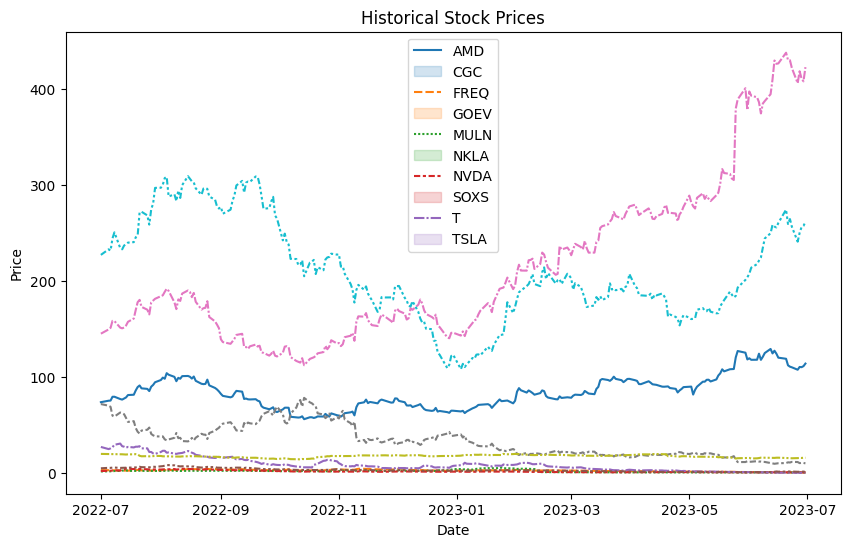

In [48]:
# Step 17: Visualize the historical stock prices for the tickers
plt.figure(figsize=(10, 6))
sns.lineplot(data=data)
plt.title("Historical Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(data.columns)
plt.show()


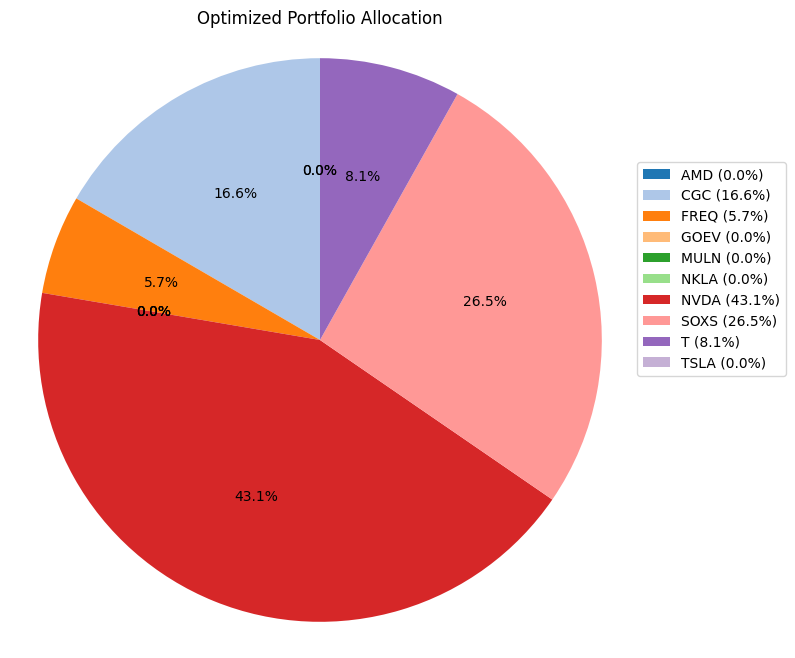

In [50]:
# Step 18: Visualize the optimized portfolio allocation
plt.figure(figsize=(8, 8))
colors = sns.color_palette('tab20')[0:len(data.columns)]

# Filter out stocks with 0% allocation
non_zero_weights = [weight for weight in optimized_weights if weight > 0]
non_zero_tickers = [ticker for ticker, weight in zip(data.columns, optimized_weights) if weight > 0]

plt.pie(non_zero_weights, labels=None, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Optimized Portfolio Allocation")
plt.axis('equal')

# Create a legend outside the pie chart with stock tickers and allocation percentages
plt.legend(labels=[f"{ticker} ({weight*100:.1f}%)" for ticker, weight in zip(non_zero_tickers, non_zero_weights)],
           loc='upper left', bbox_to_anchor=(1, 0.8))
plt.show()

